In [1]:
import copy
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchvision

from lightly.data import LightlyDataset
from lightly.loss import NTXentLoss
from lightly.models import ResNetGenerator
from lightly.models.modules.heads import MoCoProjectionHead
from lightly.models.utils import (
    batch_shuffle,
    batch_unshuffle,
    deactivate_requires_grad,
    update_momentum,
)
from lightly.transforms import MoCoV2Transform, utils

from lightly.loss import NTXentLoss
from lightly.models.modules import MoCoProjectionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.transforms.moco_transform import MoCoV2Transform
from lightly.utils.scheduler import cosine_schedule
from colorization import Colorization


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use NVIDIA GPU
    print('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps")   # Use Apple's Metal (for M1/M2 Macs)
    print('mps')
else:
    device = torch.device("cpu") 
    print('cpu')

cuda


In [3]:
num_workers = 8
batch_size = 256  # STL-10 is larger, so a smaller batch size may be better for memory
memory_bank_size = 4096
seed = 1
max_epochs = 100

path_to_data = "../data"

import copy
import torch
import torchvision
from torch import nn
from torchvision.datasets import STL10

from lightly.loss import NTXentLoss
from lightly.models.modules import MoCoProjectionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.transforms.moco_transform import MoCoV2Transform
from lightly.utils.scheduler import cosine_schedule

In [4]:
# First load the pretrained colorization model
resnet = torchvision.models.resnet18()
colorization_backbone = nn.Sequential(*list(resnet.children())[:-1])
colorization_model = Colorization(colorization_backbone)
# colorization_model.load_state_dict(torch.load("colorization_model_weights_final.pth"))
colorization_model.load_state_dict(torch.load("colorization_model_weights_final.pth", map_location=device))


# Use the trained colorization backbone for MoCo
class MoCo(nn.Module):
    def __init__(self, backbone):
        super().__init__()

        self.backbone = backbone
        self.projection_head = MoCoProjectionHead(512, 512, 128)

        self.backbone_momentum = copy.deepcopy(self.backbone)
        self.projection_head_momentum = copy.deepcopy(self.projection_head)

        deactivate_requires_grad(self.backbone_momentum)
        deactivate_requires_grad(self.projection_head_momentum)

    def forward(self, x):
        query = self.backbone(x).flatten(start_dim=1)
        query = self.projection_head(query)
        return query

    def forward_momentum(self, x):
        key = self.backbone_momentum(x).flatten(start_dim=1)
        key = self.projection_head_momentum(key).detach()
        return key

# Use the pretrained colorization backbone
model = MoCo(colorization_model.backbone)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

/tmp/ipykernel_2597149/4090068172.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  colorization_model.load_state_dict(torch.load("colorization_model_weights_final.pth", m

MoCo(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [5]:
transform = MoCoV2Transform(input_size=96)
dataset = torchvision.datasets.STL10(
    root='../data', split='train+unlabeled', download=True, transform=transform
)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

criterion = NTXentLoss(memory_bank_size=(4096, 128))
optimizer = torch.optim.SGD(model.parameters(), lr=0.06)

Files already downloaded and verified


In [6]:
import json

epochs = 200
losses = []

print("Starting Training")
for epoch in range(epochs):
    total_loss = 0
    momentum_val = cosine_schedule(epoch, epochs, 0.996, 1)
    for batch in dataloader:
        x_query, x_key = batch[0]
        update_momentum(model.backbone, model.backbone_momentum, m=momentum_val)
        update_momentum(
            model.projection_head, model.projection_head_momentum, m=momentum_val
        )
        x_query = x_query.to(device)
        x_key = x_key.to(device)
        query = model(x_query)
        key = model.forward_momentum(x_key)
        loss = criterion(query, key)
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss.item())
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")
    
    # Save training progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
            'losses': losses
        }
        torch.save(checkpoint, f'models/checkpoint_epoch_{epoch+1}.pth')
        
        # Save losses to JSON
        with open('training_losses.json', 'w') as f:
            json.dump({'losses': losses}, f)

new_backbone = nn.Sequential(*list(model.backbone.children())[:-1])
torch.save(new_backbone.state_dict(), 'models/backbone_weights_fin.pth')

Starting Training
epoch: 00, loss: 8.19207
epoch: 01, loss: 7.81875
epoch: 02, loss: 7.60079
epoch: 03, loss: 7.50652
epoch: 04, loss: 7.45317
epoch: 05, loss: 7.41505
epoch: 06, loss: 7.38697
epoch: 07, loss: 7.36343
epoch: 08, loss: 7.34536
epoch: 09, loss: 7.32777
epoch: 10, loss: 7.31518
epoch: 11, loss: 7.30202
epoch: 12, loss: 7.28940
epoch: 13, loss: 7.27803
epoch: 14, loss: 7.26934
epoch: 15, loss: 7.26036
epoch: 16, loss: 7.25061
epoch: 17, loss: 7.24512
epoch: 18, loss: 7.23620
epoch: 19, loss: 7.23073
epoch: 20, loss: 7.22590
epoch: 21, loss: 7.21867
epoch: 22, loss: 7.21560
epoch: 23, loss: 7.20884
epoch: 24, loss: 7.20365
epoch: 25, loss: 7.20324
epoch: 26, loss: 7.19579
epoch: 27, loss: 7.19305
epoch: 28, loss: 7.19030
epoch: 29, loss: 7.18507
epoch: 30, loss: 7.18206
epoch: 31, loss: 7.17905
epoch: 32, loss: 7.17477
epoch: 33, loss: 7.17483
epoch: 34, loss: 7.17087
epoch: 35, loss: 7.16686
epoch: 36, loss: 7.16372
epoch: 37, loss: 7.16171
epoch: 38, loss: 7.15864
epoch: 

In [10]:
import matplotlib.pyplot as plt
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


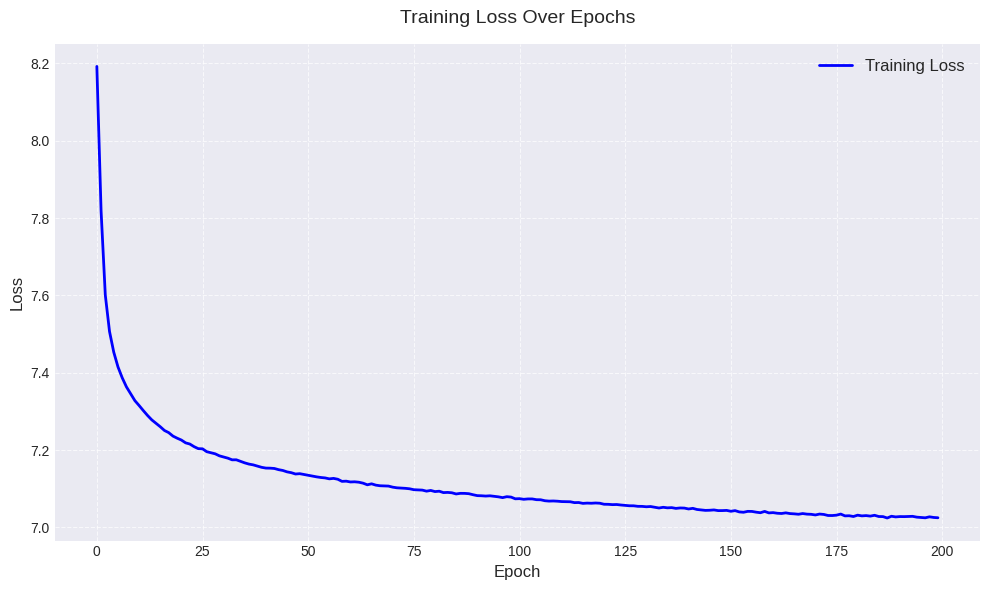

In [12]:
import json
import matplotlib.pyplot as plt

# Load the saved training losses from JSON
with open('training_losses.json', 'r') as f:
    data = json.load(f)

# Extract losses
losses = data['losses']

# Plot the losses
plt.style.use('seaborn-v0_8-darkgrid')  # Use a valid style
plt.figure(figsize=(10, 6))
plt.plot(losses, color='blue', linewidth=2, label='Training Loss')

# Labeling the plot
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Over Epochs', fontsize=14, pad=15)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Save and display the plot
plt.tight_layout()
plt.savefig('training_loss_plot.png', dpi=300, bbox_inches='tight')
plt.show()


# Downstream Task

In [13]:
new_backbone  = nn.Sequential(*list(model.backbone.children())[:-1])
torch.save(new_backbone.state_dict(), 'models/colorization_model_weights_final.pth')

In [14]:
class ClassificationNet(nn.Module):
    def __init__(self, backbone, num_classes):
        super(ClassificationNet, self).__init__()
        self.backbone = backbone
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        features = self.backbone(x)
        pooled_features = nn.AdaptiveAvgPool2d((1, 1))(features)
        pooled_features = pooled_features.view(pooled_features.size(0), -1)
        output = self.classifier(pooled_features)
        return output

classification_model = ClassificationNet(new_backbone, num_classes=10).to(device)

In [15]:
from torchvision import transforms
classification_transform = transforms.Compose([
    # transforms.RandomResizedCrop(96),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # RGB for classification
])

In [16]:
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import STL10
stl10_train = STL10(root='../data', split='train', download=True, transform=classification_transform)
stl10_test = STL10(root='../data', split='test', download=True, transform=classification_transform)

# Fine-tuning: Load training data for classification task
train_loader = DataLoader(stl10_train, batch_size=64, shuffle=True)

# Testing: Load test data for final evaluation
test_loader = DataLoader(stl10_test, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
import os
import json
import torch.nn as nn
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # multi-class classification
optimizer = optim.Adam(classification_model.parameters(), lr=1e-4)

# Ensure directory for saving models and logs exists
save_dir = 'models/downstream'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Initialize JSON log file
log_file = os.path.join(save_dir, 'training_log.json')
training_logs = {"epoch_losses": []}

# Training Loop
num_epochs = 150
for epoch in range(num_epochs):
    classification_model.train()  
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = classification_model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Save epoch loss to JSON
    training_logs["epoch_losses"].append({"epoch": epoch + 1, "loss": avg_loss})

    # Save model weights every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save(
            classification_model.state_dict(),
            os.path.join(save_dir, f'classification_model_weights_epoch_{epoch+1}.pth')
        )

# Save final model weights
final_model_path = os.path.join(save_dir, 'classification_model_weights_final_200.pth')
torch.save(classification_model.state_dict(), final_model_path)

# Save the JSON logs
with open(log_file, 'w') as file:
    json.dump(training_logs, file, indent=4)


Epoch [1/150], Loss: 2.2440
Epoch [2/150], Loss: 2.0889
Epoch [3/150], Loss: 1.9050
Epoch [4/150], Loss: 1.7177
Epoch [5/150], Loss: 1.5733
Epoch [6/150], Loss: 1.4520
Epoch [7/150], Loss: 1.3606
Epoch [8/150], Loss: 1.2907
Epoch [9/150], Loss: 1.2188
Epoch [10/150], Loss: 1.1571
Epoch [11/150], Loss: 1.1102
Epoch [12/150], Loss: 1.0563
Epoch [13/150], Loss: 1.0124
Epoch [14/150], Loss: 0.9711
Epoch [15/150], Loss: 0.9274
Epoch [16/150], Loss: 0.8871
Epoch [17/150], Loss: 0.8510
Epoch [18/150], Loss: 0.8079
Epoch [19/150], Loss: 0.7569
Epoch [20/150], Loss: 0.7269
Epoch [21/150], Loss: 0.6913
Epoch [22/150], Loss: 0.6523
Epoch [23/150], Loss: 0.6215
Epoch [24/150], Loss: 0.5776
Epoch [25/150], Loss: 0.5329
Epoch [26/150], Loss: 0.5016
Epoch [27/150], Loss: 0.4551
Epoch [28/150], Loss: 0.4253
Epoch [29/150], Loss: 0.3834
Epoch [30/150], Loss: 0.3557
Epoch [31/150], Loss: 0.3188
Epoch [32/150], Loss: 0.2805
Epoch [33/150], Loss: 0.2522
Epoch [34/150], Loss: 0.2331
Epoch [35/150], Loss: 0

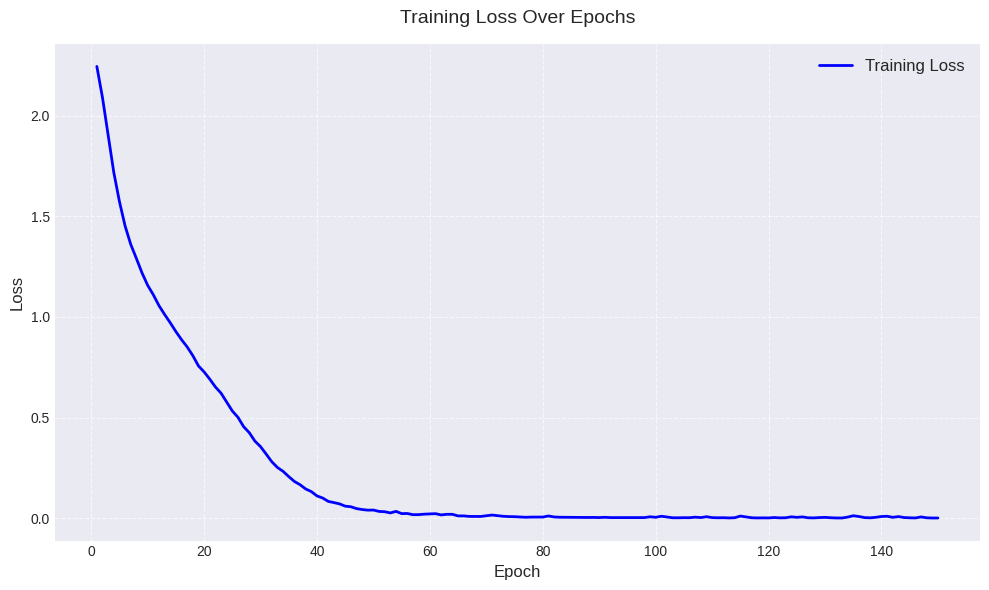

In [18]:
import json
import matplotlib.pyplot as plt

# Load training logs from JSON
log_file = 'models/downstream/training_log.json'
with open(log_file, 'r') as file:
    training_logs = json.load(file)

# Extract epochs and losses
epochs = [entry["epoch"] for entry in training_logs["epoch_losses"]]
losses = [entry["loss"] for entry in training_logs["epoch_losses"]]

# Plot training loss
plt.style.use('seaborn-v0_8-darkgrid')  # Use a valid style
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, color='blue', linewidth=2, label='Training Loss')

# Labeling the plot
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Over Epochs', fontsize=14, pad=15)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Save and display the plot
plt.tight_layout()
plt.savefig('training_loss_plot.png', dpi=300, bbox_inches='tight')
plt.show()


In [19]:
# Evaluation
classification_model.eval()  # Set model to evaluation mode
correct = 0
top_5_correct = 0
top_3_correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = classification_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        _, predicted_3 = torch.topk(outputs.data, k=3, dim=1)
        correct_3 = predicted_3.eq(labels.unsqueeze(1).expand_as(predicted_3))
        top_3_correct += correct_3.any(dim=1).sum().item()

        _, predicted_5 = torch.topk(outputs.data, k=5, dim=1)
        correct_5 = predicted_5.eq(labels.unsqueeze(1).expand_as(predicted_5))
        top_5_correct += correct_5.any(dim=1).sum().item()



accuracy = 100 * correct / total
top_5 = 100 * top_5_correct / total
top_3 = 100 * top_3_correct / total
print(f'Top-1 Accuracy of the model on the test set: {accuracy:.2f}%')
print(f'Top-5 Accuracy of the model on the test set: {top_5:.2f}%')
print(f'Top-3 Accuracy of the model on the test set: {top_3:.2f}%')

Top-1 Accuracy of the model on the test set: 64.86%
Top-5 Accuracy of the model on the test set: 95.95%
Top-3 Accuracy of the model on the test set: 89.38%
